# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [52]:
# imports
import panel as pn
pn.extension('plotly')
#adding interact function
from panel.interact import interact
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [57]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("MBOX_KEY")
# Set the mapbox access token
px.set_mapbox_access_token(map_box_api)

# Import Data

In [54]:
# Import the necessary CSVs to Pandas DataFrames

#importing the housing price and rent data per year and neighborhood 
sfo_data = pd.read_csv("Data/sfo_neighborhoods_census_data.csv", index_col="year")

# Load neighborhoods coordinates data
neighborhood_corr = pd.read_csv("Data/neighborhoods_coordinates.csv" , index_col='Neighborhood')


- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

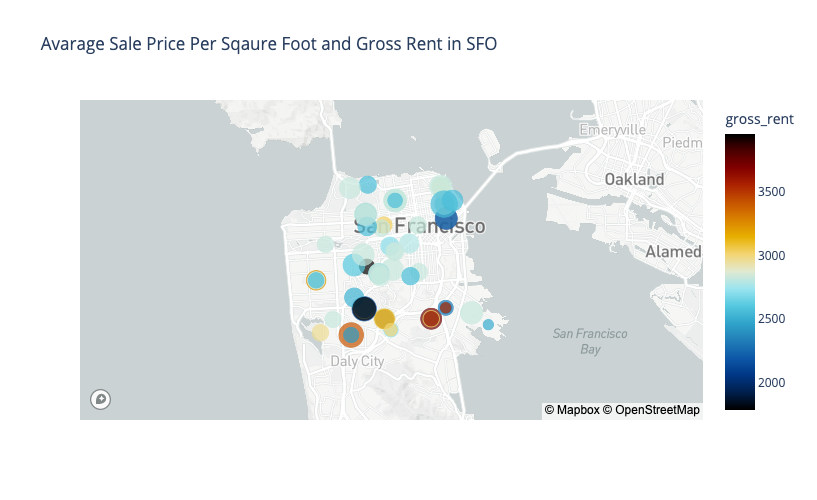

In [59]:
# Calculate the mean values for each neighborhood
neighborhood_avg = round(sfo_data.groupby(by='neighborhood').mean(),2)
neighborhood_avg.head()
    
# Join the average values with the neighborhood locations
neighborhood_avg_corr = pd.concat([neighborhood_avg , neighborhood_corr], axis= 1, join='inner').reset_index()
neighborhood_avg_corr.rename(columns={'index':'Neighborhood'} , inplace = True)
    

# Create a scatter mapbox to analyze neighborhood info
px.scatter_mapbox(
        neighborhood_avg_corr , 
        lat='Lat' ,
        lon = 'Lon', 
        size = 'sale_price_sqr_foot' ,
        color = 'gross_rent' ,
        color_continuous_scale = px.colors.cyclical.IceFire,
        zoom =10 , 
        width = 700, 
        height = 500 ,
        title = "Avarage Sale Price Per Sqaure Foot and Gross Rent in SFO"
    )

In [82]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    
    # Calculate the mean number of housing units per year (hint: use groupby) 
    sfo_data_by_year = sfo_data.groupby(by="year").mean().drop(columns = ["sale_price_sqr_foot","gross_rent"])
    # converting to integers 
    sfo_data_by_year['housing_units'] = sfo_data_by_year['housing_units'].astype("int64")
    #calculate the scales using the standard deviation from the min and max     
    ymin = min(sfo_data_by_year.housing_units)- np.std(sfo_data_by_year.housing_units)
    ymax = max(sfo_data_by_year.housing_units) + np.std(sfo_data_by_year.housing_units)
    
    return sfo_data_by_year.plot( 
            kind = "bar",
            y = "housing_units",
            title="Housing Units in San Fransisco from 2010 to 2016",
            xlabel = "Year",
            ylabel = "Housing Units" ,
            ylim = [ ymin , ymax ],
            legend = False
            )
  

def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    
    # Calculate the average sale price per square foot and average gross rent
    sfo_avg_sale_rent = round(sfo_data.groupby(by="year").mean().drop(columns = "housing_units"),2)

    # converting to integers 
    sfo_avg_sale_rent['gross_rent']=sfo_avg_sale_rent['gross_rent'].astype("int64")

    # Line chart for average montly rent
    return sfo_avg_sale_rent.plot(
            kind="line",
            title="Average Gross Rent by Year",
            color= "red",
            xlabel= "Year",
            y= "gross_rent",
            ylabel= "Average Gross Rent" ,
            legend = False
            )
    
def average_sales_price():
    """Average Sales Price Per Year."""
    
    # Calculate the average sale price per square foot and average gross rent
    sfo_avg_sale_rent = round(sfo_data.groupby(by="year").mean().drop(columns = "housing_units"),2)

    # converting to integers 
    sfo_avg_sale_rent['gross_rent']=sfo_avg_sale_rent['gross_rent'].astype("int64")
    
    # Line chart for average sale price per square foot
     
    return sfo_avg_sale_rent.plot(
            kind="line",
            title="Average Price per SqFt by Year",
            color = "purple",
            xlabel= "Year",
            y= "sale_price_sqr_foot",
            ylabel= "Price per SqFt",
            legend = False
            )


def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    
    # Group by year and neighborhood and then create a new dataframe of the mean values
    sfo_by_year_neighborhood = round(sfo_data.groupby(by = ['year', 'neighborhood']).mean().reset_index(),2)

    # converting to integers 
    sfo_by_year_neighborhood[['housing_units','gross_rent']] = sfo_by_year_neighborhood[['housing_units','gross_rent']].astype("int64") 

    def avg_price_sqft_plot(Neigborhood):

        # create a temp list per chosen niegborhood
        temp_df = sfo_by_year_neighborhood[sfo_by_year_neighborhood["neighborhood"] == Neigborhood]

        #Create a hvplot and store in plot to be returned  
        plot = temp_df.hvplot.line(
            x="year",
            xlabel = "Year",
            y= "sale_price_sqr_foot",
            ylabel = "Avg. Sale Price per Square Foot", 
            title=f"Neighborhood : {Neigborhood} - Average Sale Price per SqFt Plot",
            xformatter = '%.0f',
            height = 350) 
        return plot 
    
    return interact(avg_price_sqft_plot,Neigborhood = sfo_by_year_neighborhood["neighborhood"].unique())



def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    # Group by year and neighborhood and then create a new dataframe of the mean values
    sfo_by_year_neighborhood = round(sfo_data.groupby(by = ['year', 'neighborhood']).mean().reset_index(),2)

    # converting to integers 
    sfo_by_year_neighborhood[['housing_units','gross_rent']] = sfo_by_year_neighborhood[['housing_units','gross_rent']].astype("int64") 
    
    # Getting the data from the top 10 expensive neighborhoods to own
    top_10_neighborhoods = sfo_by_year_neighborhood.groupby(by='neighborhood').mean().nlargest(10 , columns = 'sale_price_sqr_foot')
    
    # Plotting the data from the top 10 expensive neighborhoods
    return top_10_neighborhoods.hvplot.bar(
        x = "neighborhood",
        rot = 90 ,
        xlabel = "Neighborhood",
        y = "sale_price_sqr_foot", 
        ylabel = "Avg . Sale Price per Square Foot" ,
        title = "Top 10 Expensive Neighborhoods in SFO",
        height = 400
        )


def most_expensive_neighborhoods_rent_sales():
    """Comparison of Rent and Sales Prices of Most Expensive Neighborhoods."""   
    
    # Group by year and neighborhood and then create a new dataframe of the mean values
    sfo_by_year_neighborhood = round(sfo_data.groupby(by = ['year', 'neighborhood']).mean().reset_index(),2)

    # converting to integers 
    sfo_by_year_neighborhood[['housing_units','gross_rent']] = sfo_by_year_neighborhood[['housing_units','gross_rent']].astype("int64") 
    
        #creating a function to output the plot
    def top_10_expensive_plot(Neigborhood):

            # create a temp list grouping the 
            temp_df = sfo_by_year_neighborhood.groupby(by=['year','neighborhood']).mean().reset_index()
            ploting_df = temp_df.loc[temp_df['neighborhood'] == Neigborhood]

            #Create a hvplot and store in plot to be returned  
            plot = ploting_df.hvplot.bar(
                x='year' ,
                y = ['sale_price_sqr_foot' , 'gross_rent'] , 
                rot = 90 ,
                title = "Top 10 Expensive Neighborhoods in SFO" ,
                xlabel = "Neighborhood" ,
                ylabel = "Dollar Amount $" ,
                stacked = False ,
                height = 450

            )

            return plot

# plotting the interactive plot to show avg price per neighborhood
    return interact(top_10_expensive_plot,Neigborhood = sfo_by_year_neighborhood["neighborhood"].unique())
    
    
def parallel_coordinates():
    """Parallel Coordinates Plot."""

    # YOUR CODE HERE!



def parallel_categories():
    """Parallel Categories Plot."""
    
    # YOUR CODE HERE!



def neighborhood_map():
    """Neighborhood Map."""

    # Calculate the mean values for each neighborhood
    neighborhood_avg = round(sfo_data.groupby(by='neighborhood').mean(),2)
    neighborhood_avg.head()
    
    # Join the average values with the neighborhood locations
    neighborhood_avg_corr = pd.concat([neighborhood_avg , neighborhood_corr], axis= 1, join='inner').reset_index()
    neighborhood_avg_corr.rename(columns={'index':'Neighborhood'} , inplace = True)
    
    # Set the mapbox access token
    px.set_mapbox_access_token(map_box_api)
    # Create a scatter mapbox to analyze neighborhood info
    return px.scatter_mapbox(
        neighborhood_avg_corr , 
        lat='Lat' ,
        lon = 'Lon', 
        size = 'sale_price_sqr_foot' ,
        color = 'gross_rent' ,
        color_continuous_scale = px.colors.cyclical.IceFire,
        zoom =10 , 
        width = 700, 
        height = 500 ,
        title = "Avarage Sale Price Per Sqaure Foot and Gross Rent in SFO"
    )


def sunburst():
    """Sunburst Plot."""
    
    # YOUR CODE HERE!


## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

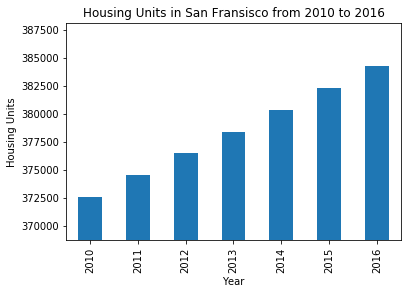

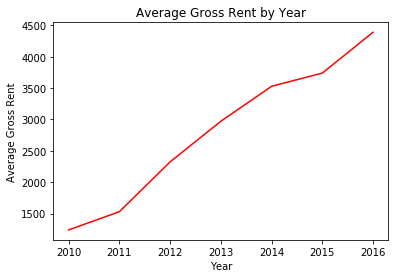

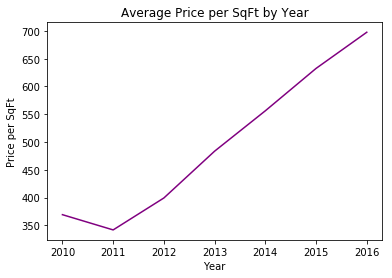

In [83]:
# Create a Title for the Dashboard
title = pn.Column("# Realestate Analysis of San Fransisco from 2010 to 2016")

# Create a tab layout for the dashboard
welcome = pn.Column("This Dashboard has data on San Fran", neighborhood_map())

year_market = pn.Column(housing_units_per_year(),average_gross_rent(),average_sales_price())

neighborhood = pn.Column(average_price_by_neighborhood(),top_most_expensive_neighborhoods(),most_expensive_neighborhoods_rent_sales())

# Create the dashboard
sfo_dashboard_page = pn.Tabs (("Welcome", welcome),("Yearly Market Analysis" , year_market),("Neighborhood Analysis" , neighborhood))

## Serve the Panel Dashboard

In [81]:
# Serve the# dashboard
sfo_dashboard.servable()

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Plotly(Figure, relayout_data={'mapbox.center': {'lat': ...})

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

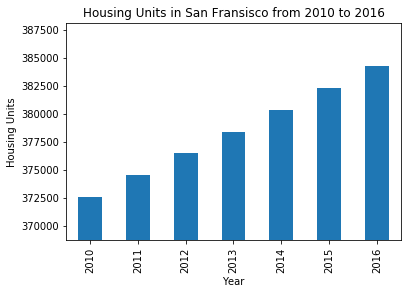

In [84]:
housing_units_per_year()

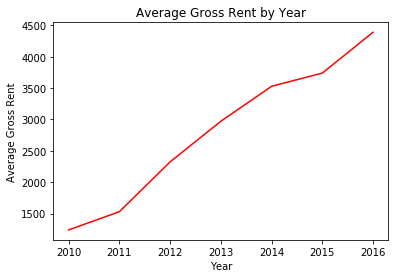

In [85]:
average_gross_rent()

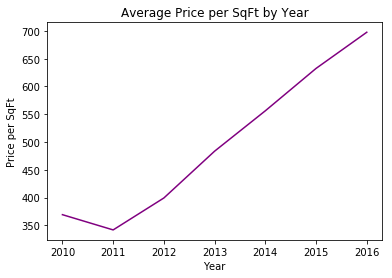

In [86]:
average_sales_price()

In [87]:
average_price_by_neighborhood()

Column
    [0] Column
        [0] Select(name='Neigborhood', options=['Alamo Square', ...], value='Alamo Square')
    [1] Row
        [0] HoloViews(Curve, name='interactive03894')

In [88]:
top_most_expensive_neighborhoods()

:Bars   [neighborhood]   (sale_price_sqr_foot)

In [89]:
most_expensive_neighborhoods_rent_sales()

Column
    [0] Column
        [0] Select(name='Neigborhood', options=['Alamo Square', ...], value='Alamo Square')
    [1] Row
        [0] HoloViews(Bars, name='interactive04231')

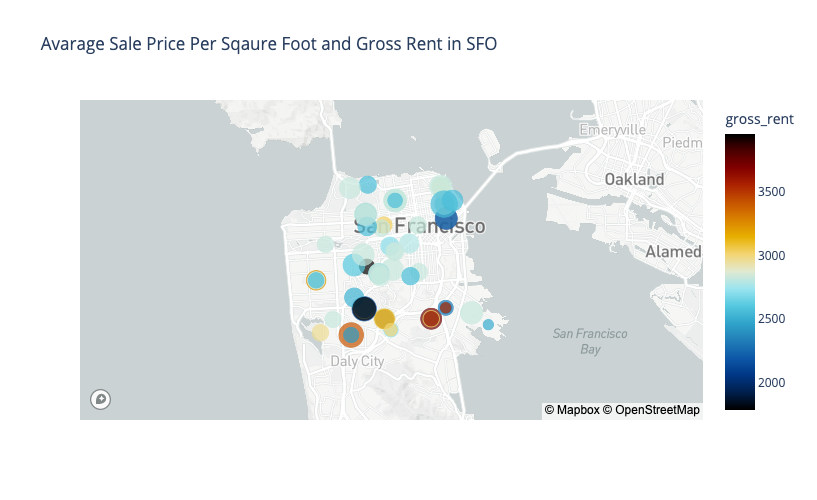

In [90]:
neighborhood_map().show()

In [91]:
# parallel_categories()

In [92]:
# parallel_coordinates()

In [93]:
# sunburst()